# Import Zone

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import os
from getpass import getpass
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Sat May  7 00:58:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!git clone https://github.com/GarrickZ2/Image-Denoising

Cloning into 'Image-Denoising'...
remote: Enumerating objects: 910, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 910 (delta 174), reused 160 (delta 77), pack-reused 626
Receiving objects: 100% (910/910), 28.48 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (473/473), done.


In [2]:
%cd /content/Image-Denoising
%ls

/content/Image-Denoising
Coordinator/        Makefile  README.md   RIDNet/
load_dataset.ipynb  PNGAN/    Restormer/


In [16]:
import sys
sys.path.append('/content/Image-Denoising/PNGAN')
from PNGAN.util.utility import visualize

In [4]:
%cd /content/Image-Denoising/Restormer
%ls
!pip install einops

/content/Image-Denoising/Restormer
basicsr/             evaluate.py         my_train.py           tb_logger/
Defocus_Deblurring/  experiment/         README.md             train.py
demo.py              INSTALL.md          setup.cfg             train.sh*
Denoising/           LICENSE.md          setup.py              VERSION
Deraining/           Motion_Deblurring/  SIDD_val_patches.zip


# Download the evaluation data

In [12]:
!wget https://storage.googleapis.com/yy3185/SIDD_val_patches.zip
!unzip -q SIDD_val_patches.zip -d ./Denoising/

--2022-05-06 23:31:01--  https://storage.googleapis.com/yy3185/SIDD_val_patches.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303792755 (290M) [application/zip]
Saving to: ‘SIDD_val_patches.zip’

SIDD_val_patches.zi 100%[===================>] 289.72M  52.6MB/s    in 5.5s    

2022-05-06 23:31:07 (52.6 MB/s) - ‘SIDD_val_patches.zip’ saved [303792755/303792755]



In [30]:
!wget https://storage.googleapis.com/yy3185/real_denoising.pth -O ./Denoising/pretrained_models/real_denoising.pth

--2022-05-06 23:47:02--  https://storage.googleapis.com/yy3185/real_denoising.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104611957 (100M) [application/octet-stream]
Saving to: ‘./Denoising/pretrained_models/real_denoising.pth’

./Denoising/pretrai 100%[===================>]  99.77M   278MB/s    in 0.4s    

2022-05-06 23:47:03 (278 MB/s) - ‘./Denoising/pretrained_models/real_denoising.pth’ saved [104611957/104611957]



In [29]:
!wget https://storage.googleapis.com/yy3185/pngan_finetuned_restormer.pth -O ./Denoising/pretrained_models/pngan_finetuned_restormer.pth

--2022-05-06 23:47:01--  https://storage.googleapis.com/yy3185/pngan_finetuned_restormer.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104600661 (100M) [application/octet-stream]
Saving to: ‘./Denoising/pretrained_models/pngan_finetuned_restormer.pth’

./Denoising/pretrai 100%[===================>]  99.75M  99.2MB/s    in 1.0s    

2022-05-06 23:47:02 (99.2 MB/s) - ‘./Denoising/pretrained_models/pngan_finetuned_restormer.pth’ saved [104600661/104600661]



# Run PSNR and SSIM evaluation

Shown below is the PSNR and SSIM metrics of our finetuned model and the baseline model on the SIDD dataset.

In [33]:
!python evaluate.py -opt ./Denoising/Options/RealDenoising_Restormer.yml --pretrained_weights ./Denoising/pretrained_models/pngan_finetuned_restormer.pth

Disable distributed.
Path already exists. Rename it to /content/Image-Denoising/Restormer/experiment/RealDenoising_Restormer_archived_20220506_235120
Path already exists. Rename it to tb_logger/RealDenoising_Restormer_archived_20220506_235120
2022-05-06 23:51:20,682 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+10018c6
	PyTorch: 1.11.0+cu113
	TorchVision: 0.12.0+cu113
2022-05-06 23:51:20,682 I

In [34]:
!python evaluate.py -opt ./Denoising/Options/RealDenoising_Restormer.yml --pretrained_weights ./Denoising/pretrained_models/real_denoising.pth

Disable distributed.
Path already exists. Rename it to /content/Image-Denoising/Restormer/experiment/RealDenoising_Restormer_archived_20220507_000047
Path already exists. Rename it to tb_logger/RealDenoising_Restormer_archived_20220507_000047
2022-05-07 00:00:47,299 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+10018c6
	PyTorch: 1.11.0+cu113
	TorchVision: 0.12.0+cu113
2022-05-07 00:00:47,299 I

# Denoising Example on SIDD

In [14]:
from PNGAN.dataset.dataset import SIDDSmallDataset, AdditiveGaussianWhiteNoise
from torch.utils.data import DataLoader

val_ds = SIDDSmallDataset('./Denoising/Datasets', data_type='val', noise_generator=AdditiveGaussianWhiteNoise())
val_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
len(val_ds), len(val_loader)

(5120, 1280)

In [10]:
%matplotlib inline

In [ ]:
import torch
from basicsr.models.archs.restormer_arch import Restormer
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader


checkpoint_file = './Denoising/pretrained_models/pngan_finetuned_restormer.pth'
checkpoint = torch.load(checkpoint_file)
yaml_file = './Denoising/Options/RealDenoising_Restormer.yml'
x = yaml.load(open(yaml_file, mode='r'), Loader=Loader)
x['network_g'].pop('type')

model_restoration = Restormer(**x['network_g'])
model_restoration.load_state_dict(checkpoint['params'])
model_restoration.to(device)
model_restoration = nn.DataParallel(model_restoration)
model_restoration.eval()

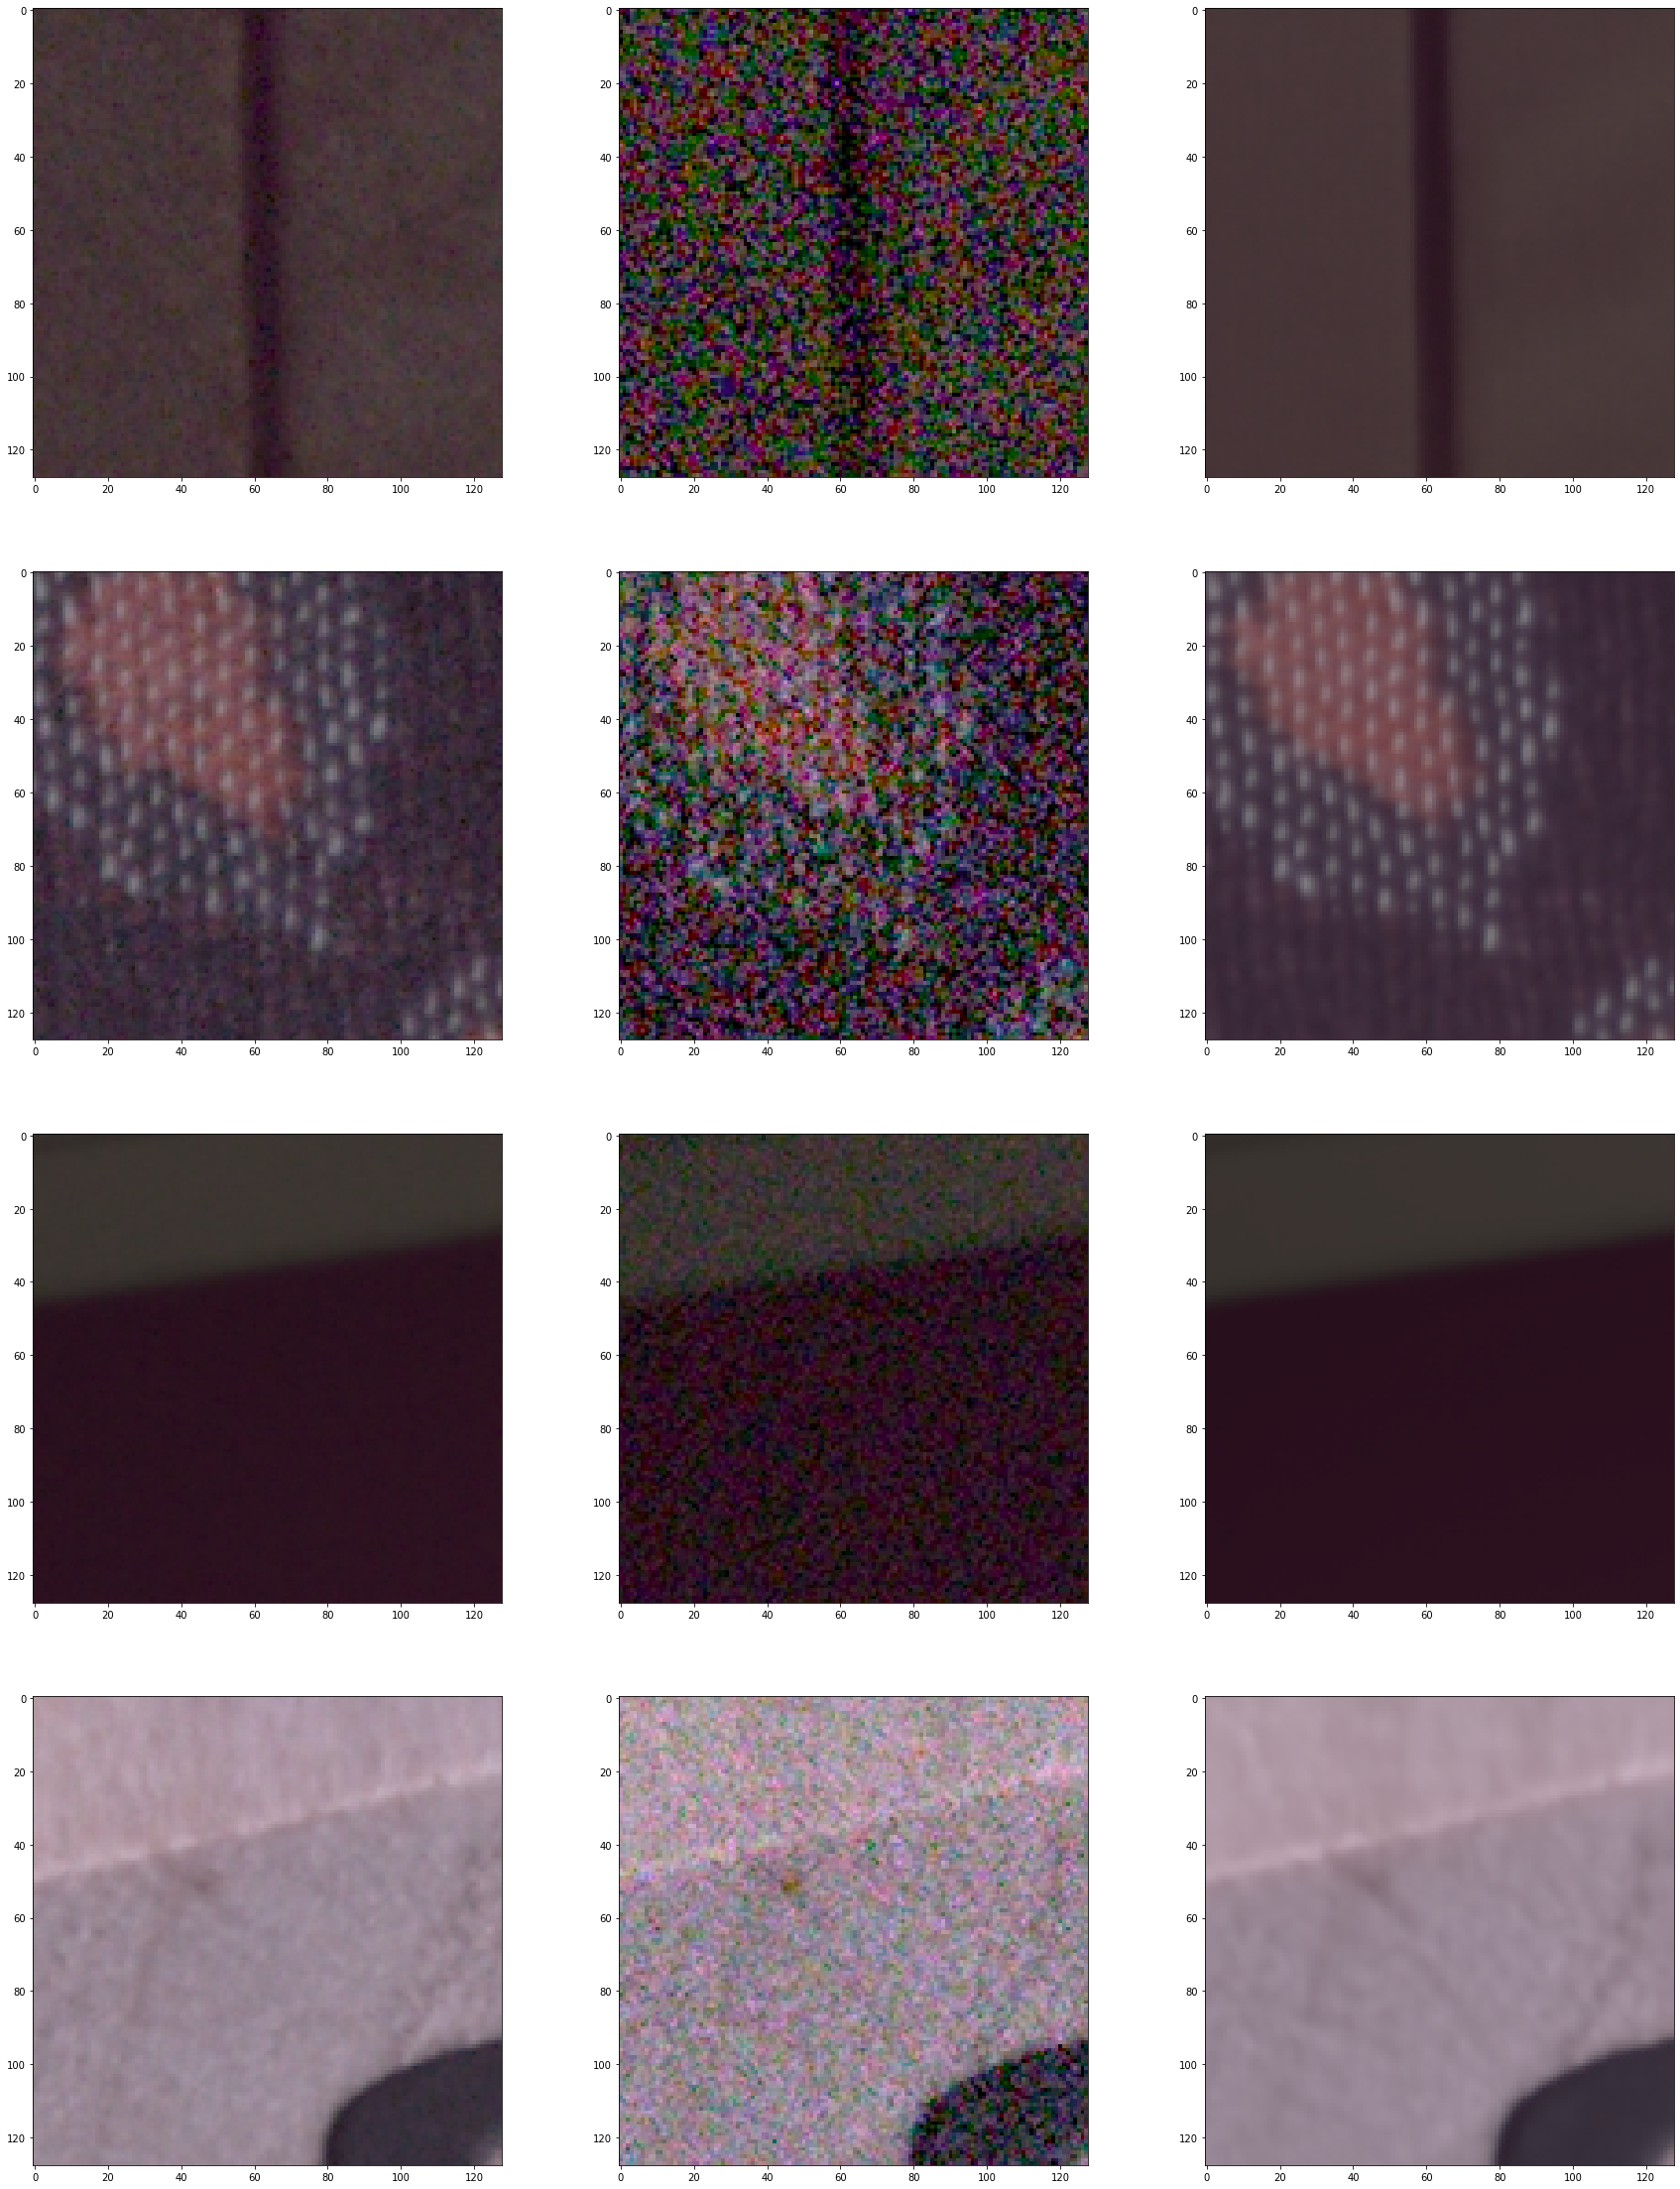

In [18]:
clean, noisy, _ = next(iter(val_loader))
denoised = model_restoration(noisy.to(device)).detach().cpu()
visualize(clean, noisy, denoised)

# Denoising Larger Crop of SIDD Images

In [17]:
!wget https://storage.googleapis.com/yy3185/SIDD_Small_sRGB_Only.zip -O /content/SIDD_Small_sRGB_Only.zip
!unzip -q /content/SIDD_Small_sRGB_Only.zip -d /content

--2022-05-07 00:43:19--  https://storage.googleapis.com/yy3185/SIDD_Small_sRGB_Only.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6615978508 (6.2G) [application/zip]
Saving to: ‘/content/SIDD_Small_sRGB_Only.zip’

/content/SIDD_Small 100%[===================>]   6.16G  47.9MB/s    in 2m 33s  

2022-05-07 00:45:53 (41.1 MB/s) - ‘/content/SIDD_Small_sRGB_Only.zip’ saved [6615978508/6615978508]



In [7]:
%matplotlib inline

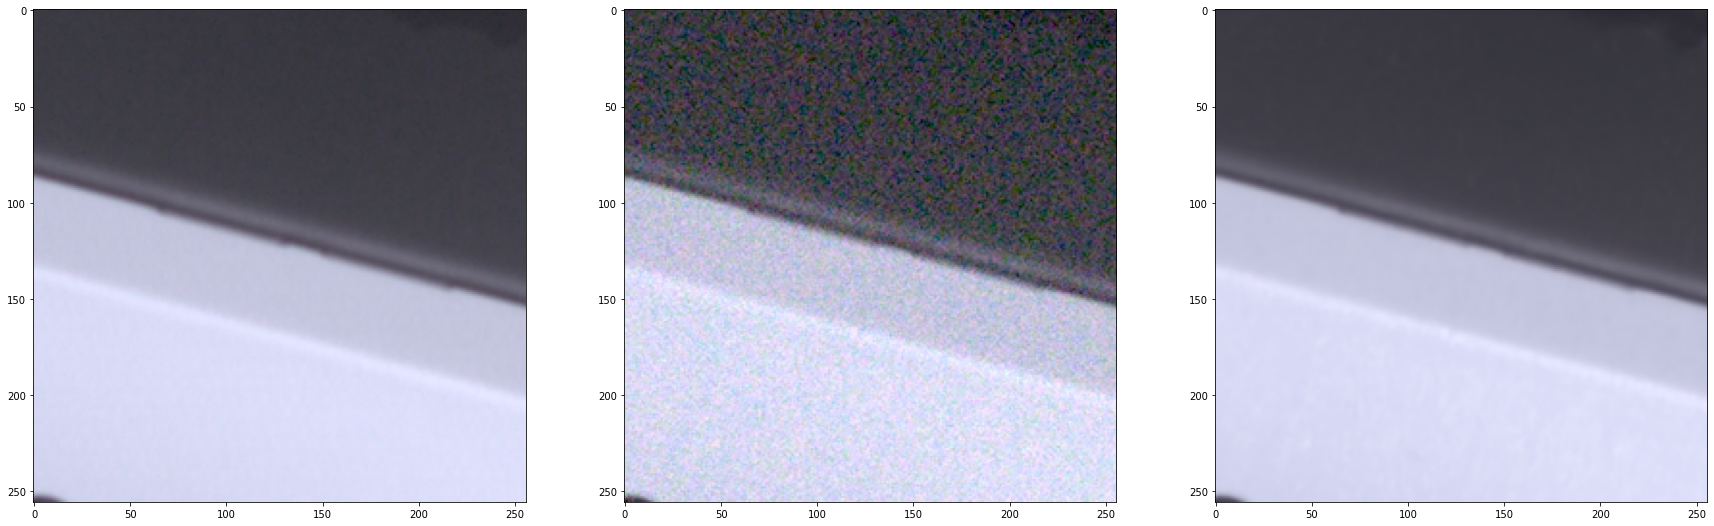

In [12]:
import os
from glob import glob
from natsort import natsorted
import cv2
import torchvision.transforms as transforms

image_index =  50# @param
size = 256 # @param
CLEAN_FILENAME = "GT_SRGB_010.PNG"
NOISY_FILENAME = "NOISY_SRGB_010.PNG"
root_dir = '/content/SIDD_Small_sRGB_Only/Data/'
dirs = natsorted(os.listdir(root_dir))
imgs_dir = dirs[image_index]

def visualize(imgs_dir, size):
  clean_filename = os.path.join(root_dir, imgs_dir, CLEAN_FILENAME)
  noisy_filename = os.path.join(root_dir, imgs_dir, NOISY_FILENAME)

  preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(size),
  ])

  postprocess = transforms.Compose([
    transforms.ToPILImage(),
  ])

  # run model
  clean = preprocess(cv2.imread(clean_filename))
  noisy = preprocess(cv2.imread(noisy_filename))
  denoised = torch.clamp(model_restoration(noisy[None].to(device)).detach().cpu()[0], 0., 1.)

  # display output
  fig, axes = plt.subplots(1, 3, figsize=(30, 10))
  axes[0].imshow(postprocess(clean))
  axes[1].imshow(postprocess(noisy))
  axes[2].imshow(postprocess(denoised))

visualize(imgs_dir, size)

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()